# Title
[]()

In [3]:

import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *


In [4]:
# set the option to wrap text within cells
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load objects

In [5]:

path = r'C:\Users\silvh\OneDrive\lighthouse\portfolio-projects\ChatGPT-sentiment-analysis\outputs\raw\2023-07-01'

prompt_dict = loadpickle('prompt_dict_2023-07-02_1903.sav', path)
response_dict = loadpickle('response_dict_2023-07-02_1903.sav', path)

	Time completed: 2023-07-03 16:13:39.355471
Dictionary keys: [1.1, 1.2, 2]
	Time completed: 2023-07-03 16:13:39.358483
Dictionary keys: [1.1, 1.2, 2]


# Process data to dataframes

In [27]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SequentialChain
import os
os.getenv('OPENAI_API_KEY')

def process_posts(df_raw):
    """
    Return the unique non-null parent_comment_message values and the associated post_message values.
    """
    df = df_raw.copy()
    df = df[['parent_comment_message', 'post_message']].drop_duplicates()
    df = df[df['parent_comment_message'].notnull()]
    df = df[df['post_message'].notnull()]

    # Sort the dataframe by 'post_message' length in descending order
    df.sort_values(by='parent_comment_message', key=lambda x: x.str.len(), ascending=False, inplace=True)
    df.drop_duplicates(subset='post_message', keep='first', inplace=True)

    results = pd.DataFrame(
        df.apply(lambda row: f"YOU: {row['post_message']}\n\nMEMBER: {row['parent_comment_message']}", axis=1).unique(),
        columns=['text'])
    
    results['text'] = results['text'].str.replace('Amanda', 'Amy')
    results['text'] = results['text'].str.replace('amanda', 'amy')
    print(f'Shape of processed DataFrame containing Facebook group posts and comments: {results.shape}')
    return results

def create_LLMChain(template, input_variables, output_key, llm=OpenAI(temperature=0, max_tokens=100)):
    """
    Create an LLMChain object.
    Parameters:
        - template (str): The template for the prompt, i.e. the value of the `template` 
            parameter in the PromptTemplate class.
        - input_variables (List[str]) 
        - output_key (str): The key of the output variable.
        - llm (OpenAI object): Default is OpenAI()

    Returns:
        - LLMChain object
    """
    prompt_template = PromptTemplate(
        template=template, input_variables=input_variables)
    chain = LLMChain(
        llm=llm, prompt=prompt_template, output_key=output_key)
    return chain, prompt_template.template

def analyze_text_sentiment(text, llm=OpenAI(temperature=0, max_tokens=200)):
    """
    Analyze the sentiment of a text.
    Parameters:
        - text (str): The text to analyze.
        - llm (OpenAI object): Default is OpenAI()

    Returns:
        - sentiment (str): The sentiment of the text.
    """
    
    # openai.api_key = os.getenv('api_openai_p')
    template_root = """
    You are the owner of a personal training business. You use a Facebook group to as a lead generation tool.
    You write posts in the group to engage with members and position yourself as \
    a coach who can help them achieve their fitness goals.
    You aim to respond quickly to comments by group members if they request information, \
    express a desire to improve their fitness, have health conditions or injuries, \
    or express dissatisfaction with their current fitness.
    Below, delimited by triple back ticks, is a post you wrote in the group and a comment from a member:, 
    """
    templates = {
        'sentiment': 'Determine the sentiment of the member comment as "positive", "neutral", or "negative".',
        'emotions': 'Determine the main emotion expressed in the member comment. Return your response as a single word.',
        'respond': 'Indicate whether you need to quickly respond to the message or not using "yes" or "no".',
    }
    template_end = 'If you are not sure of the answer, return "?"'
    chain_dict = {}
    prompt_dict = {}
    for template in templates:
        chain_dict[template], prompt_dict[template] = create_LLMChain(
            template_root+templates[template]+' ```{text}``` '+template_end, 
            input_variables=['text'], output_key=template,
            llm=llm)
    overall_chain = SequentialChain(
        chains = [chain for chain in chain_dict.values()], 
        input_variables = ['text' for chain in chain_dict.values()],
        output_variables = list(chain_dict.keys()), verbose=True
    )
    response_dict = overall_chain(text)
    return response_dict, prompt_dict

def batch_analyze_text_sentiment_from_df(messages_df, key='text'):
    response_dict = dict()
    prompt_dict = dict()
    messages_list = messages_df[key].tolist()
    failures = 0
    for iteration_id, message in enumerate(messages_list):
        # print(iteration_id, message)
        try:
            response_dict[iteration_id], prompt_dict[iteration_id] = analyze_text_sentiment(message)
        except Exception as error:
            exc_type, exc_obj, tb = sys.exc_info()
            f = tb.tb_frame
            lineno = tb.tb_lineno
            file = f.f_code.co_filename
            print("An error occurred on line", lineno, "in", file, ":", error)
            print('\t...Error making chatbot request')
            failures += 1
            if failures > 2:
                print('\t...Too many failures, stopping')
                break
    return response_dict, prompt_dict

def create_df_from_response(response):
    """
    Convert the response into a dataframe and strip white spaces at the start and end of text.
    """
    df = pd.DataFrame(response).transpose()
    for column in df.columns:
        df[column] = df[column].str.strip().str.replace('\n', ' ')
        df[column] = df[column].str.strip().str.replace('YOU:', '[YOU]')
        df[column] = df[column].str.strip().str.replace('MEMBER:', '[MEMBER]')
    return df

iteration = 2

# input_df = process_posts(df)

# response_dict[iteration_id], prompt_dict[iteration_id] = batch_analyze_text_sentiment_from_df(input_df)

results_dict = {iteration: create_df_from_response(response_dict[iteration])}
results_dict[iteration]

,text,sentiment,emotions,respond
0,"[YOU] How I stay bikini confident year round 👙 First off I need to tell you - being bikini confident has actually NOTHING to do with how you look and everything to do with how you feel. So let me tell you a little story… Once upon a time I was a self conscious, controlling perfectionist who believed that being skinny and lean would make me happy. I thought having abs and being lean were the definition of the perfect body. And I embarked on a journey to achieve ‘perfection’. I ended up exhausted, overwhelmed and disappointed 😔 I was unhappy - in a lot of elements of my life - so I decided to seek the help of a life coach. This was hard for me - as I’m a very strong independent woman so asking for help wasn’t easy. But let me tell you - hands down this changed my life. After a very difficult time in my life, I chose to work with a counsellor (for a TOTALLY different reason). So what has this got to do with me being happy in a bikini? 🤣 Seeking help from these people - changed my whole outlook on life. They helped me look internally and forced me to uncover some things I didn’t even know about myself. My mindset towards myself changed. I stopped focusing on aesthetics as a goal and started working on performance. My relationship with food did a 360 and I started viewing food as fuel instead of calories in versus calories out. I started practising gratitude and meditating. I prioritised sleep instead of ‘grinding’. And (for anyone who read the whole copy) that is how I am now bikini confident year round 👙 [MEMBER] Mind set is everything! Recently in Thailand, our last day. 12 hrs to kill before the flight, wanted to go for a swim, but didn’t want our baggage to weigh over the 25kg with wet swimmers (LOTS of shopping was done lol) so my friend and I stripped off to our bra and undies walked the 5 metres across the decking and went swimming! 😂🤣 12 mths ago before meeting u, I would never have dreamed of doing this 🤣😂🤣 you only have one body, just learn to love it! ❤️ PS you look flipping amazballz!",Positive,Empathy,No
1,"[YOU] Do it for you ❤️There will always be critics - silence them ✌️#beunapologeticallyyou [MEMBER] This comment makes me want to throat 👊🏻👊🏻👊🏻👊🏻 I’m so glad you have broad shoulders, cause I think you look AMAZBALLZ!! I’d love to have a figure like yours, but I’m a wee bit busy, so I’ll settle for the one you helped me get!! ❤️😉 If someone is doing things to please another, what a shallow life they live! Love your response stay positive and keep smiling that gorgeous smile of yours! 💪🏻❤️🦵🏻",Positive,Encouragement,No
2,"[YOU] Hey @everyone Throw me some questions for our live training tomorrow? Nutrition, exercise, weight loss etc. anything you need to know - that’s what I’m here for [MEMBER] Need some tips for tightening tummy … lost 7kg in 3 months but now got stuck in same weight for more than 2 weeks … what do I need to change??",Positive,Desire,Yes
3,[YOU] @everyone can you please send me some questions for our live training Thursday! Last weeks questions were great! Remember I’m trying to help you all as much as possible so use this opportunity 👌 [MEMBER] Did my measurements today and although my chest and hips seem to be coming down my stomach seems to be going up 😳 what am I doing wrong.,Positive,Frustration,Yes
4,"[YOU] Menopause - weights or cardio, 3 sessions a week - what to do, macros and calories - what changes, measurements [MEMBER] Thanks a million. You covered my question perfectly. I couldn't care less about calories but am trying to get the old bod healthy 🙂",Positive,Thanks,No
5,[YOU] Greetings team from Airlie Beach 👋 Reminder there will be no weekly live training next week as I am on holidays 🙏 I’m curious - have you any holidays planned this year? [MEMBER] You are less than 2 hours away from where I am thats so cool I love airlie beach just never find the time to go there anymore,Positive,Disappointment,No
6,"[YOU] ‘I’ll never get results like her’ Do you f

# Human labelling

In [23]:
cm_dict = dict()
accuracy_dict = dict()
transformed_df_dict = dict()

## sentiment

In [28]:
sentiment_hl_dict = pd.Series({
    0: 1,
    1: 1,
    2: -1,
    3: -1,
    4: 1,
    5: 1,
    6: 0,
    7: -1,
    8: 0,
    9: 1,
    10: 1,
    11: 1,
    12: 1,
    13: 0,
    14: 1,
    15: 1,
    16: 1,
    17: 1,
    18: 0
})
sentiment_hl_dict

0     1
1     1
2    -1
3    -1
4     1
5     1
6     0
7    -1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
15    1
16    1
17    1
18    0
dtype: int64

## Respond yes or no

In [68]:
respond_hl_dict = pd.Series({
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 1, 
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 1,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0
})

Accuracy of GPT model: 0.7368421052631579


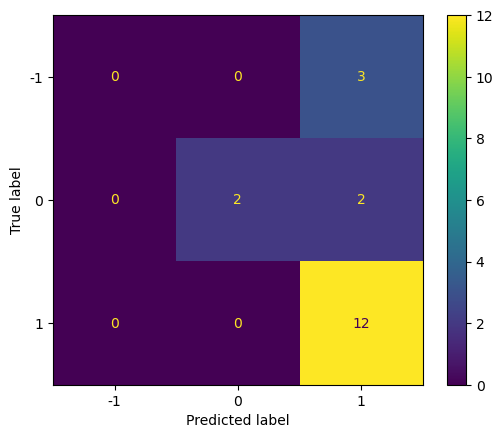

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_GPT_results(results_df, GPT_label_column, human_labels):
    """
    Determine the accuracy of the GPT model by comparing its predictions to the human labels.

    Parameters:
        - results_df (pd.DataFrame): The dataframe containing the GPT predictions.
        - GPT_label_column (str): The column name containing the GPT predictions.
        - human_labels (pd.Series): The human labels.
    
    Returns:
        - accuracy (float): The accuracy of the GPT model.
        - DataFrame of GPT predictions and human labels.
        - confusion matrix (ConfusionMatrixDisplay): The confusion matrix of GPT predictions.

    """
    transformed_df = pd.DataFrame()
    transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)
    transformed_df['human_label'] = human_labels
    transformed_df['wrong_prediction'] = transformed_df['GPT_label'] != transformed_df['human_label']
    transformed_df['wrong_prediction'] = transformed_df['wrong_prediction'].apply(lambda x: 'Yes' if x else '')
    accuracy = accuracy_score(transformed_df['human_label'], transformed_df['GPT_label'])
    print(f'Accuracy of GPT model: {accuracy}')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    # ax = ax.flatten()
    cm = ConfusionMatrixDisplay.from_predictions(transformed_df['human_label'], transformed_df['GPT_label'], ax=ax);
    return accuracy, transformed_df, fig
    
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'sentiment', sentiment_hl_dict);

## Iteration 2.1

Accuracy of GPT model for "sentiment": 0.7368421052631579


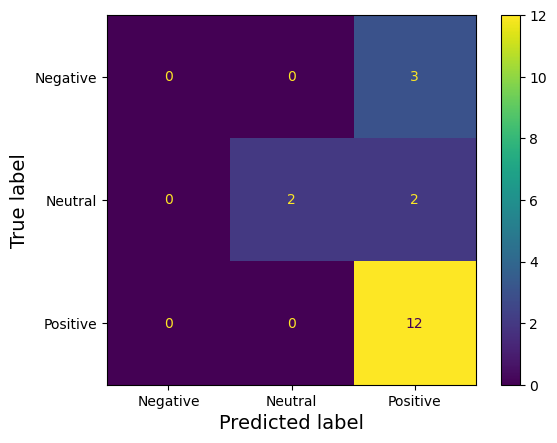

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_GPT_results(results_df, GPT_label_column, human_labels):
    """
    Determine the accuracy of the GPT model by comparing its predictions to the human labels.

    Parameters:
        - results_df (pd.DataFrame): The dataframe containing the GPT predictions.
        - GPT_label_column (str): The column name containing the GPT predictions.
        - human_labels (pd.Series): The human labels.
    
    Returns:
        - accuracy (float): The accuracy of the GPT model.
        - DataFrame of GPT predictions and human labels.
        - confusion matrix (ConfusionMatrixDisplay): The confusion matrix of GPT predictions.

    """
    transformed_df = pd.DataFrame()
    transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)
    transformed_df['human_label'] = human_labels
    transformed_df['wrong_prediction'] = transformed_df['GPT_label'] != transformed_df['human_label']
    transformed_df['wrong_prediction'] = transformed_df['wrong_prediction'].apply(lambda x: 'Yes' if x else '')
    accuracy = accuracy_score(transformed_df['human_label'], transformed_df['GPT_label'])
    print(f'Accuracy of GPT model for "{GPT_label_column}": {accuracy}')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    # ax = ax.flatten()
    cm = ConfusionMatrixDisplay.from_predictions(
        transformed_df['human_label'], transformed_df['GPT_label'], ax=ax,
        display_labels=['Negative', 'Neutral', 'Positive']);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return accuracy, transformed_df, fig
    
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'sentiment', sentiment_hl_dict);

In [63]:
transformed_df_dict[iteration]

,GPT_label,human_label,wrong_prediction
0,1,1,
1,1,1,
2,1,-1,Yes
3,1,-1,Yes
4,1,1,
5,1,1,
6,1,0,Yes
7,1,-1,Yes
8,0,0,
9,1,1,


## Iteration 2.2

Accuracy of GPT model for "sentiment": 0.7368421052631579


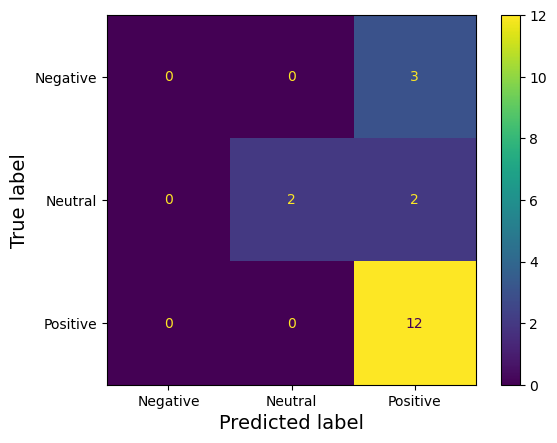

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_GPT_results(results_df, GPT_label_column, human_labels):
    """
    Determine the accuracy of the GPT model by comparing its predictions to the human labels.

    Parameters:
        - results_df (pd.DataFrame): The dataframe containing the GPT predictions.
        - GPT_label_column (str): The column name containing the GPT predictions.
        - human_labels (pd.Series): The human labels.
    
    Returns:
        - accuracy (float): The accuracy of the GPT model.
        - DataFrame of GPT predictions and human labels.
        - confusion matrix (ConfusionMatrixDisplay): The confusion matrix of GPT predictions.

    """
    transformed_df = pd.DataFrame()
    if GPT_label_column == 'respond':
        transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Yes' else 0)
        cm_display_labels = ['No', 'Yes']
    else: 
        transformed_df['GPT_label'] = results_df[GPT_label_column].apply(lambda x: 1 if x == 'Positive' else -1 if x == 'Negative' else 0)
        cm_display_labels = ['Negative', 'Neutral', 'Positive']
    transformed_df['human_label'] = human_labels
    transformed_df['wrong_prediction'] = transformed_df['GPT_label'] != transformed_df['human_label']
    transformed_df['wrong_prediction'] = transformed_df['wrong_prediction'].apply(lambda x: 'Yes' if x else '')
    accuracy = accuracy_score(transformed_df['human_label'], transformed_df['GPT_label'])
    print(f'Accuracy of GPT model for "{GPT_label_column}": {accuracy}')
    fig, ax = plt.subplots(nrows=1, ncols=1)
    # ax = ax.flatten()
    cm = ConfusionMatrixDisplay.from_predictions(
        transformed_df['human_label'], transformed_df['GPT_label'], ax=ax,
        display_labels=cm_display_labels);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    return accuracy, transformed_df, fig
    
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'sentiment', sentiment_hl_dict);

### 'respond'

Accuracy of GPT model for "respond": 0.9473684210526315


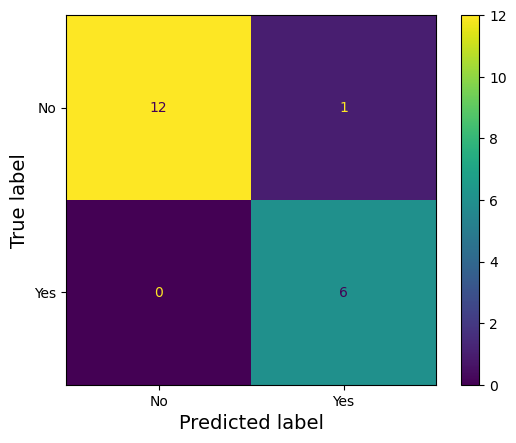

In [72]:
accuracy_dict[iteration], transformed_df_dict[iteration], cm_dict[iteration] = evaluate_GPT_results(
    results_dict[iteration], 'respond', respond_hl_dict);

In [73]:
transformed_df_dict[iteration]

,GPT_label,human_label,wrong_prediction
0,0,0,
1,0,0,
2,1,1,
3,1,1,
4,0,0,
5,0,0,
6,1,1,
7,1,1,
8,1,1,
9,0,0,


# *End of Page*